In [1]:
from keras.models import Sequential, Model
from keras.layers import Lambda, LeakyReLU, Reshape, Add, Cropping2D, Conv2DTranspose, Permute, Conv2D, MaxPooling2D, Flatten, Activation
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import tables

C:\Users\aaron\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
K.set_image_data_format( 'channels_last' )
        
model = Sequential()
        
model.add(Permute((1,2,3), input_shape=(224, 224, 3)))
        
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', name="conv1_1", trainable=False))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', name="conv1_2", trainable=False))
model.add(MaxPooling2D((2,2), strides=(2,2)))
        
model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu', name="conv2_1", trainable=False))
model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu', name="conv2_2", trainable=False))
model.add(MaxPooling2D((2,2), strides=(2,2)))
        
model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu', name="conv3_1", trainable=False))
model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu', name="conv3_2", trainable=False))
model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu', name="conv3_3", trainable=False))
model.add(MaxPooling2D((2,2), strides=(2,2)))
        
model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu', name="conv4_1", trainable=False))
model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu', name="conv4_2", trainable=False))
model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu', name="conv4_3", trainable=False))
model.add(MaxPooling2D((2,2), strides=(2,2)))
        
model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu', name="conv5_1", trainable=False))
model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu', name="conv5_2", trainable=False))
model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu', name="conv5_3", trainable=False))
model.add(MaxPooling2D((2,2), strides=(2,2)))
        
model.add(Conv2D(4096, kernel_size=(7,7), padding='same', activation='relu', name='fc6', trainable=False))
model.add(Conv2D(4096, kernel_size=(1,1), padding='same', activation='relu', name='fc7', trainable=False))

model.add(Conv2D(1, kernel_size=(1, 1), padding='same', kernel_initializer='TruncatedNormal', name='score_fr'))
model.add(LeakyReLU())
convsize = model.layers[-1].output_shape[2]
model.add(Conv2DTranspose(1, kernel_size=(4, 4), strides=(2, 2), padding='valid',  kernel_initializer='TruncatedNormal', name='score2'))
model.add(LeakyReLU())
output_size = (convsize - 1) * 2 + 4
extra_margin = output_size - convsize * 2
c = ((0, extra_margin), (0, extra_margin))
model.add(Cropping2D(cropping=c))

convsize = model.layers[-1].output_shape[2]
output_size = (convsize-1)*16+32
score_pool4 = LeakyReLU()(Conv2D(1, kernel_size=(1,1), padding='same', kernel_initializer='TruncatedNormal', name='score_pool4')(model.layers[14].output))
added = Add()([score_pool4, model.layers[-1].output])
up = LeakyReLU()(Conv2DTranspose(1,kernel_size=(32,32), strides=(16,16), padding='valid', kernel_initializer='TruncatedNormal', name='upsample')(added))
extra_margin = int((output_size - convsize*16) / 2 )
crop_margin = Cropping2D(cropping=((extra_margin, extra_margin), (extra_margin, extra_margin)))
model = Model(model.input, Lambda(lambda y: K.squeeze(y, -1))(Activation('sigmoid')(Reshape((224*224, 1))(crop_margin(up)))))

In [3]:
model.load_weights('face_weights.h5')

In [4]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
permute_1_input (InputLayer)    (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 224, 224, 3)  0           permute_1_input[0][0]            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 224, 224, 64) 1792        permute_1[0][0]                  
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 224, 224, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
max_poolin

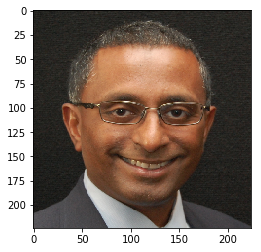

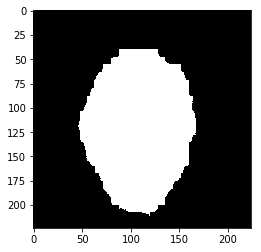

In [27]:
from PIL import Image

img = Image.open('Jacob.png').convert('RGB')
img = img.resize((224,224))
img = np.array(img).astype(np.float32)

jacob = model.predict(np.expand_dims(img, axis=0))

plt.imshow(img.astype('uint8'))
plt.show()

plt.imshow(jacob.reshape(224,224) > .2, cmap='gray')
plt.show()

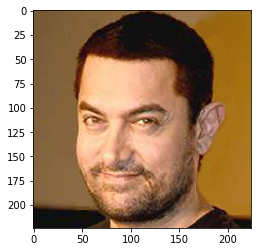

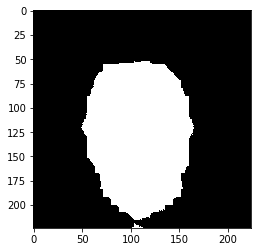

In [28]:
img2 = Image.open('ak.png')
img2 = img2.resize((224,224))
img2 = np.array(img2).astype(np.float32)

ak = model.predict(np.expand_dims(img2, axis=0))

plt.imshow(img2.astype('uint8'))
plt.show()

plt.imshow(ak.reshape(224,224) > .2, cmap='gray')
plt.show()